In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from astropy.io import fits
from matplotlib import rcParams

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR, SVC

from sklearn.linear_model import RidgeCV, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor

from sklearn.utils import shuffle
from sklearn import preprocessing

import timeit
from sklearn import linear_model

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, learning_curve



from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor

In [3]:
def read_metallicities(metfile='gal_fiboh_dr7_v5_2.fitS'):
    # Read metallicities from FITS file
    stuff = fits.open(metfile)
    data = stuff[1].data
    mets = data.field(0)
    stuff.close()
    return mets

In [4]:
from astropy.io import fits
import numpy as np


def read_info(infofile='gal_info_dr7_v5_2.fit'):
    # Read redshifts, subclass, spectrotype, E(B-V)
    with fits.open(infofile) as hdul:
        info = hdul[1].data
        red = info.field('Z').clip(0) # Get rid of -inf, negatives
        red_err = info.field('Z_ERR').clip(0) # Get rid of -inf, negatives
        red_warn = info.field('Z_WARNING')
        subclass = info.field('SUBCLASS')
        spectrotype = info.field('SPECTROTYPE')
        ebv = info.field('E_BV_SFD')
    ebvcoeff = [5.155, 3.793, 2.751, 2.086, 1.479]  # from Schlegel 1998
    return red, red_err, red_warn, spectrotype, subclass, ebv, ebvcoeff

def read_emission_lines(elinesfile='gal_line_dr7_v5_2.fit'):
    # Read emission line fluxes
    with fits.open(elinesfile) as hdul:
        data = hdul[1].data
        OII_I = data.field('OII_3726_FLUX')
        OII_II = data.field('OII_3729_FLUX')
        OII = OII_I + OII_II
        OIII_I = data.field('OIII_4959_FLUX')
        OIII_II = data.field('OIII_5007_FLUX')
        OIII = OIII_I + OIII_II
        NII_I = data.field('NII_6548_FLUX')
        NII_II = data.field('NII_6584_FLUX')
        NII = NII_I + NII_II
        Halpha = data.field('H_ALPHA_FLUX')
        Hbeta = data.field('H_BETA_FLUX')
    return OII, OIII, NII, Halpha, Hbeta

def read_masses(massfile='totlgm_dr7_v5_2.fit'):
    # Read masses
    with fits.open(massfile) as hdul:
        info = hdul[1].data
        mass = info.field('MEDIAN').clip(0)  # Get rid of -inf, neg values
        mass_16 = info.field('P16').clip(0)  # Get rid of -inf
        mass_84 = info.field('P84').clip(0)  # Get rid of -inf
    return mass, mass_16, mass_84

def read_magnitudes(magfile='SDSS_modmags.txt', errmagfile='SDSS_errmodmags.txt', correctdust=True, ebv=None):
    # Read magnitudes and uncertainties, correct for dust if needed
    mags = np.loadtxt(magfile)
    errmags = np.loadtxt(errmagfile)
    if correctdust and ebv is not None:
        for i in range(len(mags[0])):
            mags[:, i] -= ebv * ebvcoeff[i]
    mags[mags == -9999.0] = 0.05  # Replace missing values with 0.05
    return mags, errmags


In [5]:
def FeatureRanking(labels, X_train, y_train, X_test, y_test, estimator=RandomForestRegressor(n_estimators=10), plot=False, plottitle='Feature importances', color='b', nmax=0):
    estimator.fit(X_train, y_train)
    
    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]

    print('Indices:', len(indices))

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(len(indices)):
        print("%d. feature %d %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

    if plot:
        if nmax != 0:
            maxind = nmax
            aspect = min(20, int(30 * float(maxind) / float(len(indices))))
        else:
            maxind = len(indices)
            aspect = 20

        # Plot the feature importances
        fig = plt.figure(figsize=(aspect, 6))
        plt.rcParams.update({'font.size': 18})
        ax = plt.subplot(111)
        ax.set_title(plottitle)
        ax.bar(range(maxind), importances[indices[:maxind]], color=color, align="center")
        ax.set_xticks(range(maxind))
        ax.set_xticklabels(labels[indices[:maxind]], rotation=45, rotation_mode="anchor", ha="right")
        ax.set_xlim([-1, maxind])
        plt.tight_layout()
        plt.show()

    return indices

In [6]:


def PerformanceFeatures(totalfeatures, indices, labels, X_train, y_train, X_test, y_test, ylim=None, estimator=RandomForestRegressor(n_estimators=10), plottitle='Performance'):
    R2SCORE = []
    resscat = []
    OLF = []
    for i in range(1, totalfeatures + 1):
        estimator.fit(X_train[:, indices[:i]], y_train)
        y_pred, olf, rmse, rmsenool, r2 = prediction(X_train[:, indices[:i]], y_train, X_test[:, indices[:i]], y_test, estimator)
        R2SCORE.append(r2)
        OLF.append(olf)
        resscat.append(np.std(y_pred - y_test))

    rcParams.update({'font.size': 16})
    plt.semilogy(range(1, totalfeatures + 1), R2SCORE, '-', label='r2 score')
    plt.semilogy(range(1, totalfeatures + 1), OLF, '--', label='OLF')
    plt.semilogy(range(1, totalfeatures + 1), resscat, ':', label='RMSE')
    if ylim is None:
        axes = plt.gca()
        axes.set_ylim([0.01, 50])

    plt.xlim([0, totalfeatures])
    plt.tight_layout()
    plt.xlabel('Number of features in use')
    plt.legend(frameon=False, loc='best')
    plt.show()

    return

def buildsample(allmags, set, addmass, red, mass=None, bands=['u', 'g', 'r', 'i', 'z'], elinesfluxes=None, elineslabels=[]):
    nbands = allmags.shape[1]
    ncolors = nbands * (nbands - 1) // 2
    nsquaredcolors = nbands * (nbands - 1) // 2
    nelines = len(elineslabels)

    if addmass:
        masvar = 1
    else:
        masvar = 0

    resampling = False

    if set == 1:
        dataset = np.zeros([allmags.shape[0], nbands + ncolors + 1 + masvar + nelines])
        labels = np.chararray((nbands + ncolors + 1 + masvar + nelines), itemsize=12)
    elif set == 2:
        dataset = np.zeros([allmags.shape[0], nbands + ncolors + nsquaredcolors + 1 + masvar + nelines])
        labels = np.chararray((nbands + ncolors + nsquaredcolors + 1 + masvar + nelines), itemsize=12)
    else:
        return

    count = 0

    for i in range(nbands):
        dataset[:, i] = allmags[:, i]
        labels[count] = bands[i]
        count += 1

    for i in range(nbands):
        for j in range(0, i):
            dataset[:, count] = allmags[:, i] - allmags[:, j]
            labels[count] = f'{bands[i]} - {bands[j]}'
            count += 1
            if set == 2:
                dataset[:, count] = (allmags[:, i] - allmags[:, j]) ** 2
                labels[count] = f'({bands[i]} - {bands[j]})^2'
                count += 1

    for i in range(nelines):
        dataset[:, count] = elinesfluxes[:, i]
        labels[count] = elineslabels[i]
        count += 1

    if addmass:
        dataset[:, -2] = mass
        dataset[:, -1] = red
        labels[-2] = 'Mass'
        labels[-1] = 'Redshift'
    else:
        dataset[:, -1] = red
        labels[-1] = 'Redshift'

    return dataset, labels
def prediction(X_train, y_train, X_test, y_test, clf, resampling=False, olthreshold=0.2, printout=False):
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    noolpred = np.ma.compressed(np.ma.masked_where(abs(y_pred - y_test) > olthreshold, y_pred))
    nooltest = np.ma.compressed(np.ma.masked_where(abs(y_pred - y_test) > olthreshold, y_test))

    if printout:
        print('r^2 Score =', r2_score(y_test, y_pred))
        print('Mean and median absolute deviation', np.mean(abs(y_pred - y_test)), np.median(abs(y_pred - y_test)))
        print('Scatter of residuals', np.std(y_pred - y_test))
        print('RMSE', np.sqrt(np.mean(((y_pred) - (y_test)) ** 2)))
        print('Outlier fraction', 1 - float(len(noolpred)) / float(len(y_test)))
        print('Excluding outliers:')
        print('RMSE', np.sqrt(np.mean(((noolpred) - (nooltest)) ** 2)))

    return y_pred, 1 - float(len(noolpred)) / float(len(y_test)), np.sqrt(np.mean(((y_pred) - (y_test)) ** 2)), np.sqrt(np.mean(((noolpred) - (nooltest)) ** 2)), r2_score(nooltest, noolpred)


In [7]:

def makedataset(test, mets, mags, err_mags, red, err_red, bands=['u', 'g', 'r', 'i', 'z'], mass=[], err_mass=[], subclass=[], spectrotype=[], elines=[], elineslabels=[], minred=0.0, maxred=1.0, find=None): 

    if test == 1:
        minred = 0.09
        maxred = 0.12
        find = np.where(np.logical_and(mass > 0., np.logical_and(spectrotype == 'GALAXY', np.logical_and(subclass != 'AGN', np.logical_and(mags[:,2] < 18.0, np.logical_and(red > minred, np.logical_and(red < maxred, np.logical_and(np.logical_and(mets > 0.0, red_warn == 0), np.all(np.abs(mags[:,0:mags.shape[1]]) > 0.01, axis=1)))))))))
    elif test == 2:
        minred = 0.2
        maxred = 0.25
        find = np.where(np.logical_and(mass > 0., np.logical_and(spectrotype == 'GALAXY', np.logical_and(subclass != 'AGN', np.logical_and(mags[:,2] < 25, np.logical_and(red > minred, np.logical_and(red < maxred, np.logical_and(np.logical_and(mets > 0.0, red_warn == 0), np.all(mags[:,0:mags.shape[1]] > 0.01, axis=1)))))))))
    elif not find: 
        minred = minred
        maxred = maxred
        find = np.where(np.logical_and(mets > 0.0, mass > 0.0))
    
    print('Creating data set with', len(find[0]), 'objects')
    
    useelines = bool(len(elines))
    addmass = bool(len(mass))
    
    if useelines:
        elinesfluxes = np.column_stack(elines)
    else:
        elinesfluxes = np.zeros([mags.shape[0], mags.shape[1]])

    imp = SimpleImputer(missing_values=0, strategy='median')
    err_mags = np.reshape(err_mags, (-1, 1))  # Reshape err_mags to be 2D
    err_mags = imp.fit_transform(err_mags).flatten()  # Flatten back to 1D after transformation

    imp = SimpleImputer(missing_values=0, strategy='median')
    err_red = np.reshape(err_red, (-1, 1))  # Reshape err_red to be 2D
    err_red = imp.fit_transform(err_red).flatten()

    if addmass:
        err_mass = np.reshape(err_mass, (-1, 1))  # Reshape err_mass to be 2D
        err_mass = imp.fit_transform(err_mass).flatten()
    else:
        mass = np.ones(mags.shape[0])
        err_mass = np.ones(mags.shape[0])
    
    
    X, y, z, m, e, z_e, m_e, l = mags[find[0],:], mets[find[0]], red[find[0]], mass[find[0]], err_mags[find[0]], err_red[find[0]], err_mass[find[0]], elinesfluxes[find[0],:]

    return X, y, z, m, e, z_e, m_e, l, elineslabels, bands

 

In [8]:



def build_train_test(X, y, z, m, e, l, elineslabels, bands, set=2, traintestsplit=0.2, scaling=False):

    addmass = np.std(m) > 0.01
    
    nsamples = X.shape[0]

    percentile = int(nsamples * traintestsplit)
    
    # shuffle
    X, y, z, m, e, l = shuffle(X, y, z, m, e, l)
    
    if len(l) > 0:
        X_train, trainlabels = buildsample(X[percentile:, :], set, addmass, z[percentile:], mass=m[percentile:], bands=bands, elinesfluxes=l[percentile:], elineslabels=elineslabels)
        X_test, testlabels = buildsample(X[:percentile, :], set, addmass, z[:percentile], mass=m[:percentile], bands=bands, elinesfluxes=l[:percentile], elineslabels=elineslabels)
    else:
        X_train, trainlabels = buildsample(X[percentile:, :], set, addmass, z[percentile:], mass=m[percentile:], bands=bands)
        X_test, testlabels = buildsample(X[:percentile, :], set, addmass, z[:percentile], mass=m[:percentile], bands=bands)
        
    y_train, y_test = y[percentile:], y[:percentile]
    
    if scaling:
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    return X_train, y_train, X_test, y_test, trainlabels



In [9]:


def my_loss_func(pred, truth):
    return np.std(pred - truth)  # Scatter of residuals

loss = make_scorer(my_loss_func, greater_is_better=False)

In [10]:


def predict_with_cv(X, y, z, m, e, l, elineslabels, bands, clf, olthreshold=0.2, cv=10, scaling=False):
    RMSE = []
    RMSENOOL = []
    OLF = []
    R2_SCORE = []
    print('Progress...')
    for i in range(cv):
        X_train, y_train, X_test, y_test, labels = build_train_test(X, y, z, m, e, l, elineslabels, bands, scaling=scaling)
        print('CV ', str(i), '...')
        
        # Scaling
        if scaling:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Calculate residuals and outliers
        residuals = np.abs(y_pred - y_test)
        outliers = residuals > olthreshold
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmsenool = np.sqrt(mean_squared_error(y_test[~outliers], y_pred[~outliers]))
        r2 = r2_score(y_test, y_pred)
        
        # Append metrics to lists
        RMSE.append(rmse)
        RMSENOOL.append(rmsenool)
        OLF.append(np.mean(outliers))
        R2_SCORE.append(r2)
        
    print('Average OLF/RMSE/RMSE with no OL/r2 score', np.mean(OLF), 'pm', np.std(OLF), np.mean(RMSE), 'pm', np.std(RMSE), np.mean(RMSENOOL), 'pm', np.std(RMSENOOL), np.mean(R2_SCORE), 'pm', np.std(R2_SCORE))
    
    return y_pred, np.mean(OLF), np.mean(RMSE), np.mean(RMSENOOL), np.mean(R2_SCORE)


In [11]:



def plot_multi_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                              n_jobs=1, train_sizes=np.linspace(.1, 1.0, 6), scoring='neg_mean_squared_error'):
    
    plt.title(title)
    plt.xlabel("Fraction of training examples")
    plt.ylabel("RMSE")
    train_sizes_pct = train_sizes
    colors = ["b", "g"]

    for j, (X_data, y_data) in enumerate(zip(X, y)):
        _, train_scores, test_scores = learning_curve(
            estimator[j], X_data, y_data, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
        train_scores_mean = -np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = -np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        plt.grid()
        plt.fill_between(train_sizes_pct, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color=colors[j])
        plt.plot(train_sizes_pct, test_scores_mean, 'o-', color=colors[j],
                 label="Test set " + str(j+1))
        plt.fill_between(train_sizes_pct, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color=colors[j])

    plt.legend(loc="best", frameon=False)
    plt.tight_layout()
    if ylim is not None:
        plt.ylim(*ylim)
    return plt


In [12]:
def calculate_uncertainties(X, y, z, m, e, l, red_err, mass_err, clf, ntrials=50, traintestsplit=0.2, set=2):
    X, y, z, m, e, l, red_err, mass_err = shuffle(X, y, z, m, e, l, red_err, mass_err)
    
    addmass = np.std(m) > 0
    
    nsamples = X.shape[0]
    percentile = int(nsamples * traintestsplit)
    
    metallicities = np.zeros([ntrials, percentile])

    for j in range(ntrials):
        newmags = np.array([np.random.normal(X[:, i], e[:, i]) for i in range(X.shape[1])]).T
        
        z = np.random.normal(z, red_err)
        
        if addmass:
            m = np.random.normal(m, mass_err)
        
        X_train, trainlabels = buildsample(newmags[percentile:, :], set, addmass, z[percentile:], m[percentile:])
        X_test, testlabels = buildsample(newmags[:percentile, :], set, addmass, z[:percentile], m[:percentile])
        
        y_train, y_test = y[percentile:], y[:percentile]
        
        metallicities[j, :], olf, rmse, rmsenool, r2 = prediction(X_train, y_train, X_test, y_test, clf, olthreshold=0.2)
    
    avg_scatter = np.mean(np.std(metallicities, axis=0))
    print('Average scatter:', avg_scatter)
    
    return avg_scatter, metallicities

In [13]:

mets = read_metallicities()
red, red_err, red_warn, spectrotype, subclass, ebv, ebvcoeff = read_info()
mass, mass_lo, mass_hi = read_masses()
OII, OIII, NII, Halpha, Hbeta = read_emission_lines()
mags, errmags = read_magnitudes(correctdust=True)  


In [14]:
indexes_sanders = [int(index) for index in np.loadtxt('SandersIndexes.txt')]

In [15]:


# Build sample data set 1
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(1, mets, mags, errmags, red, red_err, mass=mass, err_mass=(mass_hi-mass_lo)/2, spectrotype=spectrotype, subclass=subclass)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the model
clf = RidgeCV()
y_pred, olf, rmse, rmsenool, r2 = prediction(X_train, y_train, X_test, y_test, clf, olthreshold=0.2, printout=True)



Creating data set with 25316 objects
r^2 Score = 0.29908206960534744
Mean and median absolute deviation 0.07169871323291353 0.05739986745780978
Scatter of residuals 0.0976326536892039
RMSE 0.09763450507161371
Outlier fraction 0.03712480252764616
Excluding outliers:
RMSE 0.07761808323989267


In [16]:


parameters = {
    'n_estimators': [10, 50, 100],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8]
}

ncv = 3
clf = GridSearchCV(ExtraTreesRegressor(), parameters, cv=ncv, scoring=loss, verbose=2)
clf.fit(X_train, y_train)

ETbest = clf.best_estimator_
ETbestscore = clf.best_score_

print(ETbest, ETbestscore)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   3.1s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   3.1s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   3.1s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.9s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   6.1s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   6.1s
[CV] END min_samples_leaf=2, min_samples_split=4, n_estimators=10; total time=   0.5s
[CV] END min_samples_leaf=2, min_samples_split=4, n_estimators=10; total ti

In [17]:
#dataset 2
a = np.column_stack((z, y, m))  # Combine red, mass, and mets into a single array
np.savetxt('SDSS_ts2_input.txt', a, fmt='%.6f', delimiter='\t', newline='\n')


In [18]:


# Define the parameters grid for tuning
parameters = {
    'n_estimators': [10, 20, 40],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8]
}

# Create GridSearchCV object
clf = GridSearchCV(
    RandomForestRegressor(),  # Estimator
    parameters,                # Parameters grid
    cv=ncv,                    # Number of cross-validation folds
    scoring=loss,              # Scoring metric
    verbose=2                  # Verbosity level
)

# Fit the GridSearchCV object to the training data
clf.fit(X_train, y_train)

# Get the best estimator and its score
RFbest = clf.best_estimator_
RFbestscore = clf.best_score_

print(RFbest, RFbestscore)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   2.7s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   2.7s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   2.9s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   3.5s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   2.7s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   3.3s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   7.2s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   6.6s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   7.8s
[CV] END min_samples_leaf=2, min_samples_split=4, n_estimators=10; total time=   1.7s
[CV] END min_samples_leaf=2, min_samples_split=4, n_estimators=10; total time=

In [19]:

parameters = {
    'n_estimators': [10, 50, 100],
    'loss': ['linear', 'square', 'exponential']
}

clf = GridSearchCV(
    AdaBoostRegressor(), 
    parameters,  
    cv=ncv,  
    scoring=loss, 
    verbose=2  
)

clf.fit(X_train, y_train)
Adabest = clf.best_estimator_
Adabestscore = clf.best_score_

print(Adabest, Adabestscore)



Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .......................loss=linear, n_estimators=10; total time=   0.4s
[CV] END .......................loss=linear, n_estimators=10; total time=   0.5s
[CV] END .......................loss=linear, n_estimators=10; total time=   0.5s
[CV] END .......................loss=linear, n_estimators=50; total time=   2.2s
[CV] END .......................loss=linear, n_estimators=50; total time=   2.3s
[CV] END .......................loss=linear, n_estimators=50; total time=   1.4s
[CV] END ......................loss=linear, n_estimators=100; total time=   3.2s
[CV] END ......................loss=linear, n_estimators=100; total time=   1.9s
[CV] END ......................loss=linear, n_estimators=100; total time=   1.3s
[CV] END .......................loss=square, n_estimators=10; total time=   0.5s
[CV] END .......................loss=square, n_estimators=10; total time=   0.3s
[CV] END .......................loss=square, n_es

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

parameters = {
    'C': [1, 10, 100],
    'gamma': [0.01, 0.1, 0.5]
}
clf = GridSearchCV(
    SVR(kernel='rbf'),  
    parameters, 
    cv=ncv,  # Number of cross-validation folds
    scoring=loss,  
    verbose=2  
)
clf.fit(X_train, y_train)
SVRbest = clf.best_estimator_
SVRbestscore = clf.best_score_
print(SVRbest, SVRbestscore)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ....................................C=1, gamma=0.01; total time=  10.8s
[CV] END ....................................C=1, gamma=0.01; total time=   9.1s
[CV] END ....................................C=1, gamma=0.01; total time=  11.2s
[CV] END .....................................C=1, gamma=0.1; total time=   7.4s
[CV] END .....................................C=1, gamma=0.1; total time=   9.3s
[CV] END .....................................C=1, gamma=0.1; total time=  10.4s
[CV] END .....................................C=1, gamma=0.5; total time=  10.7s
[CV] END .....................................C=1, gamma=0.5; total time=  10.2s
[CV] END .....................................C=1, gamma=0.5; total time=   9.6s
[CV] END ...................................C=10, gamma=0.01; total time=  10.3s
[CV] END ...................................C=10, gamma=0.01; total time=  11.0s
[CV] END ...................................C=10,

In [21]:

ETbest1 = ExtraTreesRegressor(
    bootstrap=False, 
    criterion='mse', 
    max_depth=None, 
    max_features='auto',
    max_leaf_nodes=None, 
    min_samples_leaf=8,
    min_samples_split=2, 
    n_estimators=100, 
    n_jobs=1, 
    oob_score=False,
    random_state=None, 
    verbose=0
)

RFbest1 = RandomForestRegressor(
    bootstrap=True, 
    criterion='mse', 
    max_depth=None, 
    max_features='auto',
    max_leaf_nodes=None, 
    min_samples_leaf=8,
    min_samples_split=2, 
    n_estimators=40, 
    n_jobs=1, 
    oob_score=False,
    random_state=None, 
    verbose=0
)

Adabest1 = AdaBoostRegressor(
    learning_rate=1.0, 
    loss='exponential', 
    n_estimators=50,
    random_state=None
)

SVRbest1 = SVR(
    C=1, 
    cache_size=200, 
    coef0=0.0, 
    degree=3, 
    epsilon=0.1, 
    gamma=0.1,
    kernel='rbf', 
    max_iter=-1, 
    shrinking=True, 
    tol=0.001, 
    verbose=False
)


Estimator: RidgeCV
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.02583448548291527 pm 0.0013419148924718966 0.0898305819097774 pm 0.007371339347715998 0.07058044588587746 pm 0.000520823134771632 0.40521863274196146 pm 0.10345762191855803
Time to fit: 0.4398456000490114


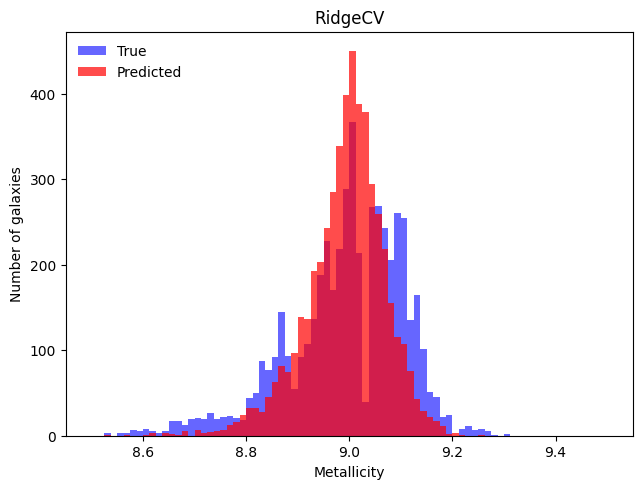

Estimator: Random Forests
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.021726249259332413 pm 0.0008832976407267588 0.07993950180366662 pm 0.0005572251420989405 0.06862397669228315 pm 0.0004087572045228848 0.5304564277922102 pm 0.00823616552731045
Time to fit: 198.4852957999683


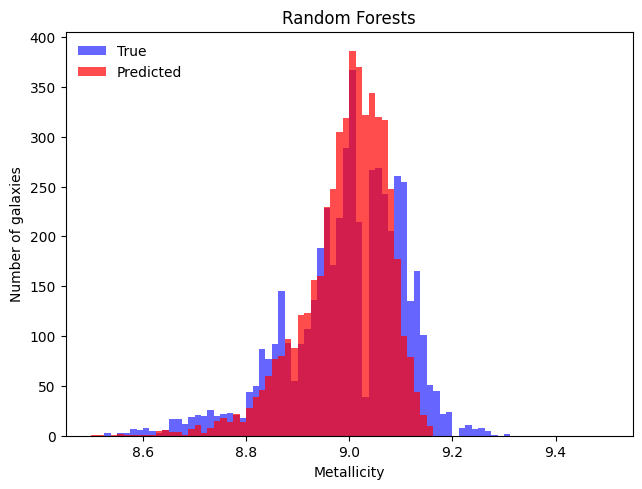

Estimator: Extra Random Trees
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.02042267430377247 pm 0.002136777141820821 0.0789626347700513 pm 0.002299546625343103 0.06831849005308695 pm 0.0006451695830195137 0.5322883618569674 pm 0.020715833849596594
Time to fit: 32.20786219998263


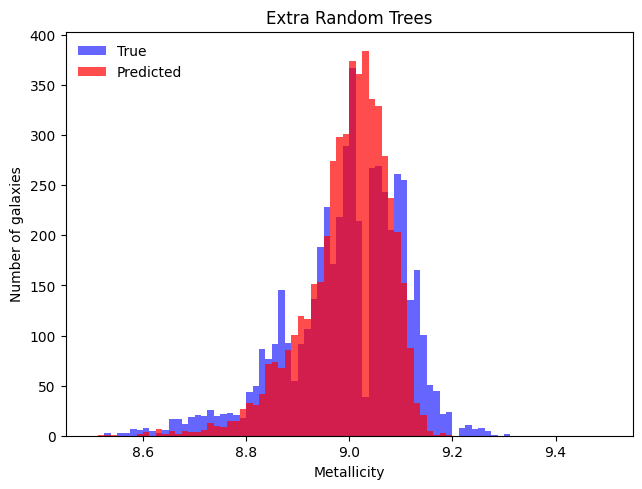

Estimator: AdaBoost
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.026585028639146753 pm 0.002595151918729108 0.09151053195251964 pm 0.00264350141018702 0.07971147346707086 pm 0.0017589152669415496 0.3889803674120487 pm 0.017909032801532217
Time to fit: 6.284913500014227


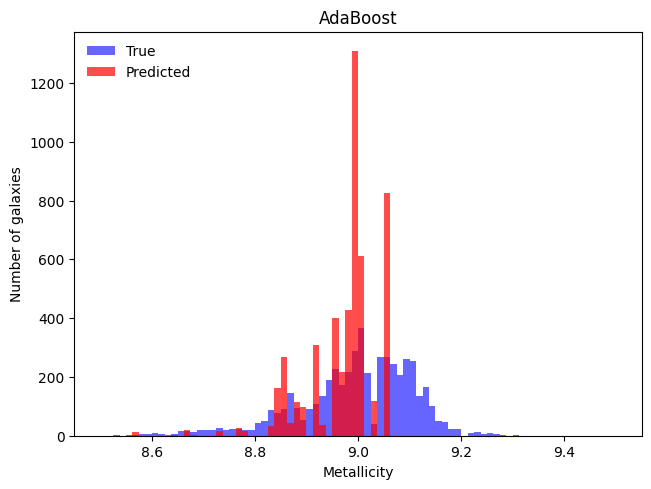

Estimator: SVM with rbf kernel
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.024886430969780764 pm 0.0013278875223362917 0.08438309019936738 pm 0.001321364550489889 0.07147131024430764 pm 0.0010422623414432556 0.4788380070912335 pm 0.008536413213160387
Time to fit: 99.27065659995424


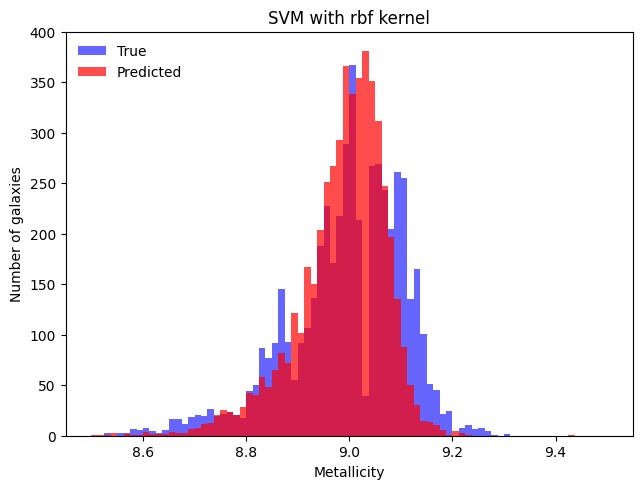

In [22]:


estimator_names = ['RidgeCV', 'Random Forests', 'Extra Random Trees', 'AdaBoost', 'SVM with rbf kernel']
estimators = [linear_model.RidgeCV(), RFbest, ETbest, Adabest, SVRbest]

for i, estimator in enumerate(estimators):
    
    print('Estimator:', estimator_names[i])
    
    start = timeit.default_timer()
    
    refmetallicities, OLF, RMSE, RMSENOOL, R2_SCORE = predict_with_cv(X, y, z, m, e, l, elineslabels, bands, estimators[i], olthreshold=0.2, cv=5)    
    stop = timeit.default_timer()
    
    print('Time to fit:', stop - start)
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    plt.title(estimator_names[i])
    plt.tight_layout()
    plt.hist(y_test, alpha=0.6, label='True', range=[8.5, 9.5], bins=80, color = colors[0])
    plt.hist(refmetallicities, label='Predicted', alpha=0.7, range=[8.5, 9.5], bins=80, color = colors[2])
    plt.xlabel('Metallicity')
    plt.ylabel('Number of galaxies')
    plt.legend(loc='upper left', frameon=False)
#    plt.savefig(estimator_names[i]+'_bm.pdf')
    plt.show()


In [24]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [10, 50, 100],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8]
}
ncv = 3
clf = GridSearchCV(ExtraTreesRegressor(), parameters, cv=ncv, scoring=loss, verbose=2)
clf.fit(X_train, y_train)

ETbest2 = clf.best_estimator_
ETbestscore2 = clf.best_score_

print(ETbest2, ETbestscore2)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END min_samples_leaf=2, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END min_samples_leaf=2, min_samples_split=4, n_estimators=10; total ti

In [25]:


parameters = {
    'n_estimators': [10, 20, 40],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8]
}

clf = GridSearchCV(RandomForestRegressor(), parameters, cv=ncv, scoring=loss, verbose=2)
clf.fit(X_train, y_train)

RFbest2 = clf.best_estimator_
RFbestscore2 = clf.best_score_

print(RFbest2, RFbestscore2)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.6s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.5s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.6s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   1.6s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   1.6s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   1.7s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   3.9s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   3.7s
[CV] END min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   2.9s
[CV] END min_samples_leaf=2, min_samples_split=4, n_estimators=10; total time=   0.8s
[CV] END min_samples_leaf=2, min_samples_split=4, n_estimators=10; total time=

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

parameters = {
    'n_estimators': [10, 50, 100],
    'loss': ['exponential', 'square', 'linear']
}

clf = GridSearchCV(
    AdaBoostRegressor(),
    parameters,
    cv=ncv,
    scoring=loss,
    verbose=2
)
clf.fit(X_train, y_train)

Adabest2 = clf.best_estimator_
Adabestscore2 = clf.best_score_

print(Adabest2, Adabestscore2)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ..................loss=exponential, n_estimators=10; total time=   0.1s
[CV] END ..................loss=exponential, n_estimators=10; total time=   0.1s
[CV] END ..................loss=exponential, n_estimators=10; total time=   0.1s
[CV] END ..................loss=exponential, n_estimators=50; total time=   0.6s
[CV] END ..................loss=exponential, n_estimators=50; total time=   0.6s
[CV] END ..................loss=exponential, n_estimators=50; total time=   0.5s
[CV] END .................loss=exponential, n_estimators=100; total time=   0.9s
[CV] END .................loss=exponential, n_estimators=100; total time=   0.9s
[CV] END .................loss=exponential, n_estimators=100; total time=   0.9s
[CV] END .......................loss=square, n_estimators=10; total time=   0.1s
[CV] END .......................loss=square, n_estimators=10; total time=   0.1s
[CV] END .......................loss=square, n_es

In [29]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

parameters = {'C': [1, 10, 100], 'gamma': [0.01, 0.1, 0.5]}
clf = GridSearchCV(
    SVR(kernel='rbf'),
    parameters,
    cv=ncv,
    scoring=loss,
    verbose=2
)
clf.fit(X_train, y_train)

SVRbest2 = clf.best_estimator_
SVRbestscore2 = clf.best_score_

print(SVRbest2, SVRbestscore2)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ....................................C=1, gamma=0.01; total time=   3.4s
[CV] END ....................................C=1, gamma=0.01; total time=   3.4s
[CV] END ....................................C=1, gamma=0.01; total time=   3.8s
[CV] END .....................................C=1, gamma=0.1; total time=   2.9s
[CV] END .....................................C=1, gamma=0.1; total time=   2.8s
[CV] END .....................................C=1, gamma=0.1; total time=   2.7s
[CV] END .....................................C=1, gamma=0.5; total time=   2.8s
[CV] END .....................................C=1, gamma=0.5; total time=   2.7s
[CV] END .....................................C=1, gamma=0.5; total time=   2.6s
[CV] END ...................................C=10, gamma=0.01; total time=   2.9s
[CV] END ...................................C=10, gamma=0.01; total time=   2.9s
[CV] END ...................................C=10,

Estimator: RidgeCV
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.026150503653960107 pm 0.002162185610650446 0.08545827822412921 pm 0.0009760291683861016 0.07103249776665546 pm 0.0005300578756757449 0.45135724598913185 pm 0.01386730152053572
Time to fit: 0.1644411999732256


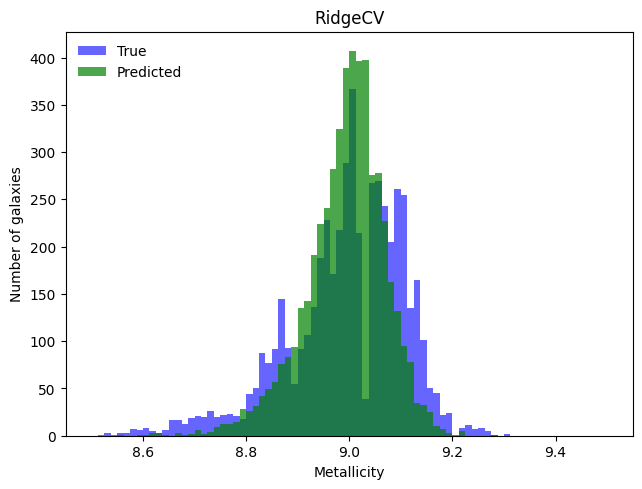

Estimator: Random Forests
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.0225162946869445 pm 0.00343465378143933 0.07983350885020184 pm 0.0020276313378864525 0.06854821238253063 pm 0.0003500095167058813 0.5217886631414592 pm 0.015283101744150318
Time to fit: 98.45789919997333


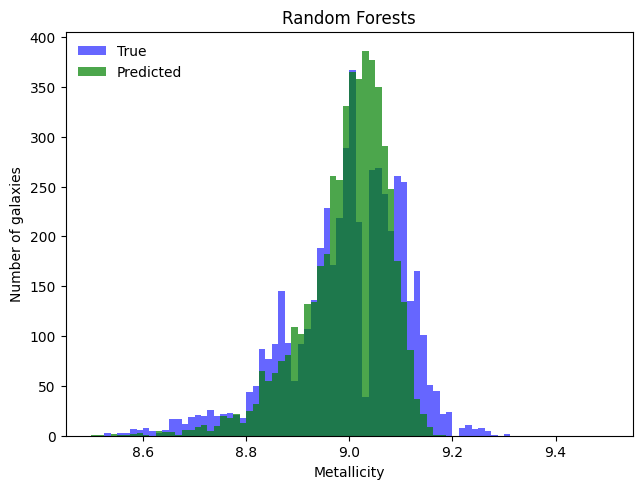

Estimator: Extra Random Trees
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.02314833102903417 pm 0.0021972639123323534 0.08077829582198551 pm 0.0015840513232743905 0.0683106667227742 pm 0.0005755423389359471 0.5222868150832276 pm 0.012693828428305135
Time to fit: 40.654556400026195


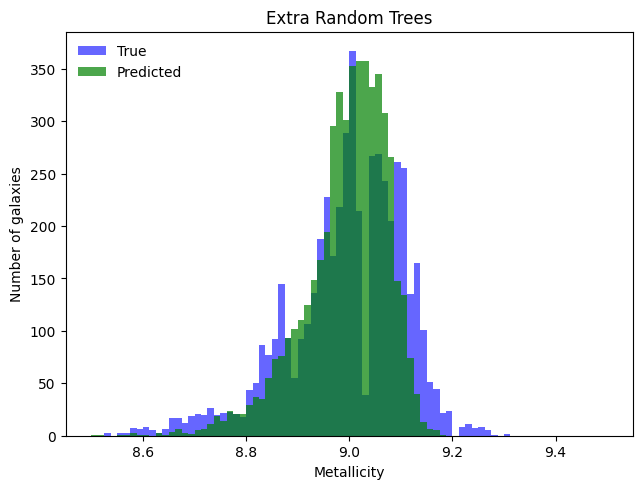

Estimator: AdaBoost
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.026703535453288563 pm 0.0023013251690506826 0.09163987674802616 pm 0.002033075632579621 0.07997076356631658 pm 0.0016859328623070621 0.37557139100022885 pm 0.03341661905234709
Time to fit: 9.716732799948659


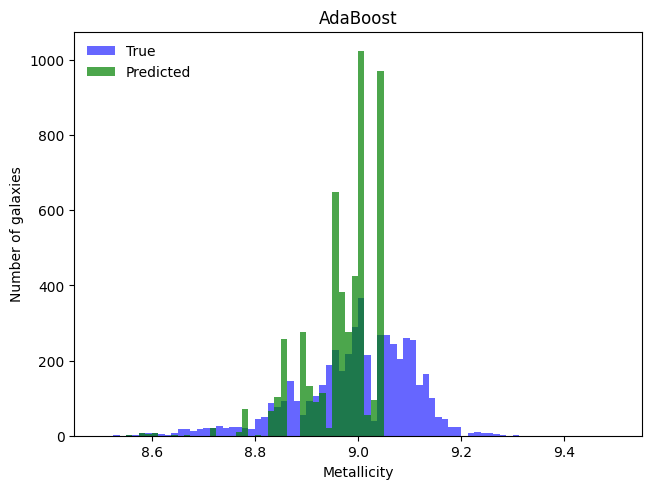

Estimator: SVM with rbf kernel
Progress...
CV  0 ...
CV  1 ...
CV  2 ...
CV  3 ...
CV  4 ...
Average OLF/RMSE/RMSE with no OL/r2 score 0.026387517282243728 pm 0.0015431187031107732 0.08558543320496585 pm 0.0009501767728691545 0.07160165415331766 pm 0.000388560178572345 0.47785065155047174 pm 0.018452864962724837
Time to fit: 95.88463640003465


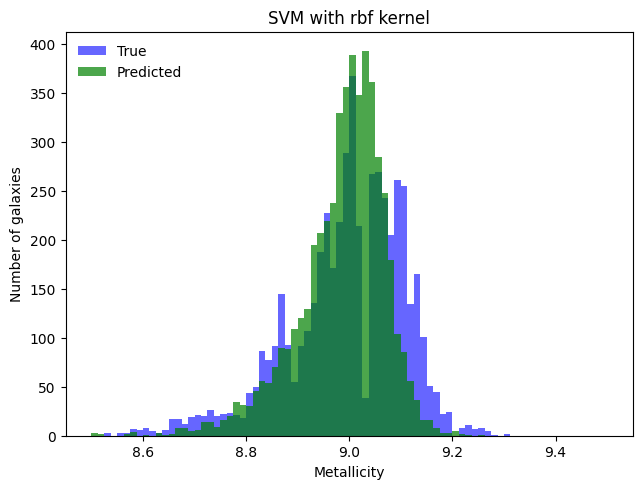

In [30]:
estimator_names = ['RidgeCV', 'Random Forests', 'Extra Random Trees', 'AdaBoost', 'SVM with rbf kernel']
estimators = [linear_model.RidgeCV(), RFbest2, ETbest2, Adabest2, SVRbest2]

for i, estimator in enumerate(estimators):
    
    print('Estimator:', estimator_names[i])
    
    start = timeit.default_timer()
    
    refmetallicities, OLF, RMSE, RMSENOOL, R2_SCORE = predict_with_cv(X, y, z, m, e, l, elineslabels, bands, estimators[i], olthreshold=0.2, cv=5)    
    stop = timeit.default_timer()
    
    print('Time to fit:', stop - start)
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    plt.title(estimator_names[i])
    plt.tight_layout()
    plt.hist(y_test, alpha=0.6, label='True', range=[8.5, 9.5], bins=80, color = colors[0])
    plt.hist(refmetallicities, label='Predicted', alpha=0.7, range=[8.5, 9.5], bins=80, color = colors[1])
    plt.xlabel('Metallicity')
    plt.ylabel('Number of galaxies')
    plt.legend(loc='upper left', frameon=False)
#    plt.savefig(estimator_names[i]+'_bm.pdf')
    plt.show()

In [41]:

X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(1, mets, mags, errmags, red, red_err, mass=mass, err_mass=(mass_hi-mass_lo)/2, spectrotype=spectrotype, subclass=subclass)
X_train, y_train, X_test, y_test, labels = build_train_test(X, y, z, m, e, l, elineslabels, bands,traintestsplit=.2)


Creating data set with 25316 objects


In [42]:

indices_ET1 = FeatureRanking(labels, X_train, y_train, X_test, y_test, estimator=ETbest, plot=True, plottitle='Ranking of features, ERT, test set 1', color='b', nmax=27)


SyntaxError: invalid syntax (2223181986.py, line 1)

In [ ]:
PerformanceFeatures(X_train.shape[1], indices_ET1, labels, X_train, y_train, X_test, y_test, estimator=ETbest1, plottitle='Performance_ERT_testset1')


In [ ]:
X, y, z, m, e, z_e, m_e, l, elineslabels, bands = makedataset(2, mets, mags, errmags, red, red_err, mass=mass, err_mass=(mass_hi-mass_lo)/2, spectrotype=spectrotype, subclass=subclass)
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Call to FeatureRanking
indicesET2 = FeatureRanking(labels, X_train, y_train, X_test, y_test, estimator=ETbest2, plot=True, plottitle='Ranking of features, ERT, test set 2', color='g', nmax=27)

In [ ]:
# Call to PerformanceFeatures
PerformanceFeatures(X_train.shape[1], indicesET2, labels, X_train, y_train, X_test, y_test, estimator=ETbest2, plottitle='Performance_ERT_testset2')